In [1]:
import pandas as pd
import numpy as np
import scipy
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import fbprophet as Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.utilities import regressor_coefficients
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings("ignore")
import os
import glob
#from dask.distributed import Client
#import statsmodels.api as sm


In [2]:
#df_EE_BA_train = df_EE_BA[df_EE_BA['ds'] <'2022-01-01']
#sns.lineplot(x = 'ds', y = 'y',data = df_EE_BA_train)
#df_EE_BA_test = df_EE_BA[(df_EE_BA['ds'] >='2022-01-01') & (df_EE_BA['ds'] <='2022-01-31')]
#sns.lineplot(x = 'ds', y = 'y',data = df_EE_BA_test)

In [3]:
def obtain_forecast_predictor(df, is_year_seasonal, predict_days):
    df_pred = df[['ds','pred']]
    df_pred = df_pred.rename(columns={'pred': 'y'})
    print('---------------------CALCULATING PREDICTOR FORECAST----------------------------------------------')
    model = Prophet.Prophet(yearly_seasonality = is_year_seasonal)
    model.add_country_holidays(country_name='RU')
    model.fit(df_pred)
    forecast = predict_future_days(model,predict_days)
    aux = forecast[['yhat']].rename(columns={'yhat': 'pred_forecast'}).values
    fig = model.plot(forecast)
    plt.show()
    return aux


def optimize_parameters(df, is_year_seasonal, country_name, initial, horizon, period, parallel_mode):
    print('----------------------OPTIMIZING THE PARAMETERS---------------------------------------------------')
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        #'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative'],
        'yearly_seasonality': [is_year_seasonal],
    }
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here
    mapes = []
    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet.Prophet(**params).add_country_holidays(country_name=country_name).add_regressor('pred').fit(df)  # Fit model with given params
        # m.add_country_holidays(country_name='RU')
        df_cv = cross_validation(m, initial=str(initial)+' days', horizon = str(horizon)+' days', period = str(period)+' days', parallel=parallel_mode)
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        mapes.append(df_p['mape'].values[0])
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    tuning_results['mape'] = mapes
    best_params = all_params[np.argmin(rmses)]
    #rmse = tuning_results.iloc[[np.argmin(rmses)]]['rmse'].values[0]
    #mape = tuning_results.iloc[[np.argmin(rmses)]]['mape'].values[0]
    #best_params['rmse'] = rmse
    #best_params['mape'] = mape
    print(best_params)
    print('----------OPTIMIZING THE PARAMETERS: DONE----------------------------------------------------')
    return best_params

def predict_future_days(model, predict_days):
    print('-----------PREDICTING FUTURE DAYS------------------------------------------------------')
    future = model.make_future_dataframe(periods=predict_days)
    forecast = model.predict(future)
    print('----------PREDICTING FUTURE DAYS: DONE----------------------------------------------------')
    return forecast

def predict_future_days_withpred(model, forecast_predictor, predict_days):
    future = model.make_future_dataframe(periods=predict_days)
    future['pred'] = forecast_predictor
    forecast = model.predict(future)
    return forecast

def calculate_model_accuracy(model,initial,horizon,period, parallel_mode):
    print('----------CALCULATING MODEL ACCURACY----------------------------------------------------')
    df_cv = cross_validation(model, initial=str(initial)+' days', horizon = str(horizon)+' days',period = str(period)+' days',parallel=parallel_mode)
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p.head())
    fig = plot_cross_validation_metric(df_cv, metric='mape')
    plt.show(fig)
    print('----------CALCULATING MODEL ACCURACY: DONE----------------------------------------------------')
    return df_p

def read_data(path, sep):
    print('------------------READING DATA--------------------------------------------------------------------')
    df = pd.read_table(path, sep)
    df.head()
    df['ds'] = pd.to_datetime(df['ds'])
    df.head()
    #df = df[["p_date", "Brand Auction Ads Revenue"]].rename(columns={'p_date': 'ds', 'Brand Auction Ads Revenue': 'y'})
    
    #we start the time series from the first date in the historical that had a revenue greater than zero
    first_date = getfirst_pandas(lambda x: x.y > 0, df)['ds']
    df = df[df['ds']>=first_date]
    df.head()
    sns.lineplot(x = 'ds', y = 'y',data = df)
    plt.show()
    df = df[['ds','y','pred']]
    print('------------------READING DONE--------------------------------------------------------------------')
    return df

def getfirst_pandas(condition, df):
    return df[condition(df)].iloc[0]

['EE_BrandAuction.txt', 'METAP_BrandAuction.txt']
--------------PROCESSING A NEW FILE--------------------------------
EE_BrandAuction.txt
------------------READING DATA--------------------------------------------------------------------


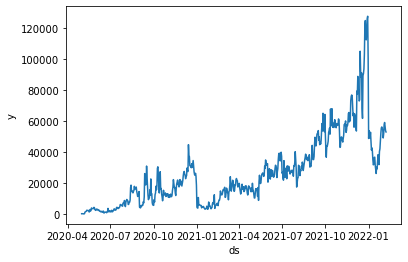

------------------READING DONE--------------------------------------------------------------------
------------------PARAMETER CONFIGURATION--------------------------------------------------------------------
applying yearly seasonality?
True
648
advised initial:
500
------------------FITTING THE MODEL--------------------------------------------------------------------
----------------------OPTIMIZING THE PARAMETERS---------------------------------------------------


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-10-10 00:00:00 and 2021-12-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000259F093BFA0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-10-10 00:00:00 and 2021-12-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000259F0954670>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-10-10 00:00:00 and 2021-12-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000259F09863A0>
INFO:fbprophet:Disabling daily seasonali

In [ ]:
input_dir = 'C:/product_files/'
input_sep = '\t'
input_files = os.listdir(input_dir)
print(input_files)

output_forecast_dir = 'C:/forecasts/'
output_bestparams_dir = 'C:/bestparams/'

#clean forecast output folder
#output_forecast_ls = glob.glob(output_forecast_dir+'*')
#for f in output_forecast_ls:
#    os.remove(f)
    
#clean best params output folder
#output_bestparams_ls = glob.glob(output_bestparams_dir +'*')
#for f in output_bestparams_ls:
#    os.remove(f)

#min days in time series acceptable to kick off Prophet
min_sample_size = 180
is_year_seasonal = False
days_in_year = 365
#period lengths to check for cross-validation 
horizon = 60
#spacing between cutoffs
period=round(horizon/2)
#period = 60
#prediction length for unobserved data
predict_days = 60
#processing of cross-validation. To be changed when put in prod to parallel="threads"
parallel = 'processes'
#do we need to optimize parameters?
optimize_parameters_active = True
#successful file processing counter
counter = 0
#forecasts dataframe
all_forecasts = pd.DataFrame()


for f in input_files:
    print('--------------PROCESSING A NEW FILE--------------------------------')
    print(f)
    df = read_data(input_dir+str(f),input_sep)
    n = len(df)
    print('------------------PARAMETER CONFIGURATION--------------------------------------------------------------------')
    
    if n < min_sample_size:
        print('--------FILE DOES NOT HAVE THE REQUIRED SAMPLE SIZE-------------------------------------')
        continue
    #understanding if yearly seasonality applies
    if n > days_in_year:
        is_year_seasonal = True
    print('applying yearly seasonality?')
    print(is_year_seasonal)

    #initial training period
    initial = horizon * 3
    print(n)

    #we increase the training period to at least 500 when initial < 365 and we have some more than 1 year data and buffer for cross-val
    if n > days_in_year and initial < days_in_year and ((n-500)>=(period+horizon)):
        initial = 500

    print('advised initial:')
    print(initial)

    print('------------------FITTING THE MODEL--------------------------------------------------------------------')
    
    if optimize_parameters_active == True:
        best_params = optimize_parameters(df[['ds','y','pred']], is_year_seasonal, 'RU', initial, horizon, period, parallel)   
        model = Prophet.Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                      seasonality_prior_scale = best_params['seasonality_prior_scale'],
                      #holidays_prior_scale = best_params['holidays_prior_scale'],
                      seasonality_mode =  best_params['seasonality_mode'],
                      yearly_seasonality = best_params['yearly_seasonality'])
        model.add_country_holidays(country_name='RU')
        model.add_regressor('pred')
        model.fit(df[['ds','y','pred']])
        best_params_df = pd.DataFrame.from_dict(best_params, orient='index')
        best_params_df.to_csv(output_bestparams_dir+str(f)+".csv")

    else:
        model = Prophet.Prophet(yearly_seasonality = is_year_seasonal)
        model.add_regressor('pred')
        model.add_country_holidays(country_name='RU')
        model.fit(df[['ds','y','pred']])
    
    print(model.train_holiday_names)
    print('the regression coefficients')
    print(regressor_coefficients(model))
    forecast_predictor = obtain_forecast_predictor(df, is_year_seasonal, predict_days)
    forecast = predict_future_days_withpred(model, forecast_predictor, predict_days)
    df_p = calculate_model_accuracy(model,initial,horizon, period,parallel)
    mape = df_p['mape'].values[0]
    
    if counter == 0:
        aux = forecast[['ds','yhat','yhat_lower', 'yhat_upper']].rename(columns={'yhat': 'yhat_'+str(f), 'yhat_lower': 'yhat_lower_'+str(f), 'yhat_upper': 'yhat_upper_'+str(f) }).tail(predict_days)
        aux['mape'] = mape
        aux = aux.rename(columns={'mape': 'mape_'+str(f)})
        all_forecasts = aux
     
    else:
        aux = forecast[['ds','yhat','yhat_lower', 'yhat_upper']].rename(columns={'yhat': 'yhat_'+str(f), 'yhat_lower': 'yhat_lower_'+str(f), 'yhat_upper': 'yhat_upper_'+str(f) }).tail(predict_days)
        aux['mape'] = mape
        aux = aux.rename(columns={'mape': 'mape_'+str(f)})
        all_forecasts = all_forecasts.merge(aux, right_on ='ds', left_on = 'ds', how='inner')
        
   
    fig = model.plot(forecast)
    plt.show()
    fig = model.plot_components(forecast)
    plt.show()
    print('--------------FILE PROCESSED--------------------------------')
    counter = counter + 1   

all_forecasts.to_csv(output_forecast_dir+'all_forecasts.csv')
print('----------------PROGRAM HAS FINALIZED---------------------------')